In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import matplotlib.pyplot as plt # visualization package
import seaborn as sns

import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

# Data Loading

In [3]:
# for kaggle
train_df = pd.read_csv('/kaggle/input/data-storm-5-0/train_kaggle.csv')
test_df = pd.read_csv('/kaggle/input/data-storm-5-0/test_kaggle.csv')

/tmp/ipykernel_33/638559108.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/kaggle/input/data-storm-5-0/train_kaggle.csv')


## Basic View of Data Tables

In [5]:
train_df.shape

(774155, 6)

In [6]:
test_df.shape

(40749, 5)

In [7]:
train_df.Customer_ID.describe()

count    7.741530e+05
mean     1.038708e+07
std      2.234795e+05
min      1.000000e+07
25%      1.019354e+07
50%      1.038708e+07
75%      1.058062e+07
max      1.077415e+07
Name: Customer_ID, dtype: float64

In [8]:
test_df.Customer_ID.describe()

count    40749.000000
mean     20375.000000
std      11763.367396
min          1.000000
25%      10188.000000
50%      20375.000000
75%      30562.000000
max      40749.000000
Name: Customer_ID, dtype: float64

## Missing Value Analysis

In [9]:
print('Number of Missing Values per Column - Training')
train_df.shape[0] - train_df.count()

Number of Missing Values per Column - Training


Customer_ID          2
outlet_city          2
luxury_sales        35
fresh_sales         41
dry_sales           30
cluster_catgeory     1
dtype: int64

In [10]:
print('Percentage of Missing Values per Column - Training')
(train_df.shape[0]/ train_df.count() - 1)*100

Percentage of Missing Values per Column - Training


Customer_ID         0.000258
outlet_city         0.000258
luxury_sales        0.004521
fresh_sales         0.005296
dry_sales           0.003875
cluster_catgeory    0.000129
dtype: float64

Since the percentage of the missing values is very low - we could choose to drop these rows if required

But missing values regarding sales columns such as `luxury_sales`, `fresh_sales` and `dry_sales` could be imputed as 0 where the missing value could relate to no purchases by the customer in that category

In [11]:
print('Number of Missing Values per Column - Testing')
test_df.shape[0] - test_df.count()

Number of Missing Values per Column - Testing


Customer_ID     0
outlet_city     0
luxury_sales    0
fresh_sales     0
dry_sales       0
dtype: int64

In [12]:
train_df.Customer_ID.nunique()

774153

In [13]:
test_df.Customer_ID.nunique()

40749

### Missing Customer ID

In [14]:
train_df.loc[train_df.Customer_ID.isnull()]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
497678,NaN,Trincomalee,1682.2,2588.0,8411.0,1
497698,NaN,Jaffna,807.82,1118.52,4039.1,1


Since Customer ID is not required for the clustering, we could apply a dummy customer ID for these 2 records to retain these values

### Missing Outlet city 

In [15]:
train_df.loc[train_df.outlet_city.isnull()]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
497599,10387530.0,NaN,1309.36,1611.52,6848.96,1
497703,10107604.0,NaN,1576.5,1891.8,7041.7,1


The outlet could be imputed with most common store if required. Else since it is only 2 rows, the rows can be dropped as well

In [17]:
train_df.outlet_city.value_counts().sort_values(ascending=False)

outlet_city
Colombo                   41031
Batticaloa                41012
Galle                     41010
Kalmunai                  40711
Negombo                   40703
Jaffna                    40675
Katunayake                40649
Kandy                     40534
Trincomalee               40528
Gampaha                   40252
Peliyagoda                37151
Nuwara Eliya              37102
Dehiwala-Mount Lavinia    36839
Kotte                     36788
Panadura                  36726
Wattala                   36721
Kaduwela                  36695
Homagama                  36639
Moratuwa                  36417
Kelaniya                  35970
Name: count, dtype: int64

As seen above it is difficult to impute with the most common outlet almost all stores behave in the same manner. It would be best to drop the records with missing outlets

### Missing Values of Luxury Sales, Fresh Sales and Dry Sales 

In [18]:
train_df.loc[train_df.luxury_sales.isnull()]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
4234,10101878.0,Dehiwala-Mount Lavinia,NaN,1686.36,9556.04,4
4333,10361798.0,Kotte,NaN,NaN,6589.44,4
5375,10556752.0,Moratuwa,NaN,1328.88,7751.8,4
5408,10321643.0,Peliyagoda,NaN,NaN,3630.09,4
78367,10424117.0,Kotte,NaN,NaN,3472.08,4
78380,10343473.0,Peliyagoda,NaN,NaN,7337.4,4
174628,10207785.0,Kelaniya,NaN,9322.5,2683.75,2
327258,10615996.0,Kelaniya,NaN,8554.92,2073.92,2
327259,10346205.0,Dehiwala-Mount Lavinia,NaN,4391.1,940.95,2
327260,10722463.0,Nuwara Eliya,NaN,5384.92,1425.42,2


In [19]:
train_df.loc[train_df.luxury_sales.isnull()].cluster_catgeory.value_counts()

cluster_catgeory
5    8
1    7
4    6
3    6
2    5
6    3
Name: count, dtype: int64

Most customers without luxury sales are in categories 5, 1, 4

In [20]:
train_df.loc[train_df.fresh_sales.isnull()]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
4326,10531406.0,Kaduwela,925.8,NaN,4011.8,4
4327,10311229.0,Panadura,2374,NaN,7715.5,4
4333,10361798.0,Kotte,NaN,NaN,6589.44,4
4929,10414692.0,Kaduwela,1780.8,NaN,NaN,4
5379,10600529.0,Wattala,1405.4,NaN,4637.82,4
5403,10484539.0,Peliyagoda,1167.2,NaN,4085.2,4
5408,10321643.0,Peliyagoda,NaN,NaN,3630.09,4
78367,10424117.0,Kotte,NaN,NaN,3472.08,4
78380,10343473.0,Peliyagoda,NaN,NaN,7337.4,4
78400,10504943.0,Moratuwa,2312.16,NaN,NaN,4


In [21]:
train_df.loc[train_df.fresh_sales.isnull()].cluster_catgeory.value_counts()

cluster_catgeory
4      10
1       9
6.0     8
3       7
5       4
2       3
Name: count, dtype: int64

Most customers without fresh item sales are in categories 4, 1, 6

In [22]:
train_df.loc[train_df.dry_sales.isnull()]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
4929,10414692.0,Kaduwela,1780.8,NaN,NaN,4
78400,10504943.0,Moratuwa,2312.16,NaN,NaN,4
327168,10649653.0,Kotte,626.16,3548.24,NaN,2
327169,10737280.0,Nuwara Eliya,820.2,5741.4,NaN,2
327170,10010850.0,Peliyagoda,1059.96,6456.12,NaN,2
327171,10347930.0,Homagama,1216.8,5353.92,NaN,2
327172,10351890.0,Wattala,1817.2,8826.4,NaN,2
327173,10025449.0,Nuwara Eliya,1341.72,7491.27,NaN,2
327174,10638161.0,Peliyagoda,1033.2,5018.4,NaN,2
329931,10540582.0,Kaduwela,3139.06,NaN,NaN,5


In [23]:
train_df.loc[train_df.dry_sales.isnull()].cluster_catgeory.value_counts()

cluster_catgeory
1    10
2     7
3     6
5     5
4     2
Name: count, dtype: int64

Most customers without dry item sales are in categories 1, 2, 3

In [24]:
train_df.loc[train_df['dry_sales'].isnull() & train_df['luxury_sales'].isnull() & train_df['fresh_sales'].isnull()]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory


Therefore each customer has bought at least one item category.

# Data Cleaning

## Missing Values

### Drop the records with missing values in target column

In [25]:
train_df = train_df.dropna(subset=['cluster_catgeory'])

### Create dummy customer IDs for missing ones

In [26]:
print('Last Customer ID made : ',train_df.Customer_ID.max())

Last Customer ID made :  10774154.0


In [27]:
train_df.loc[train_df.Customer_ID.isnull()]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_catgeory
497678,NaN,Trincomalee,1682.2,2588.0,8411.0,1
497698,NaN,Jaffna,807.82,1118.52,4039.1,1


In [28]:
test_df.Customer_ID.max()

40749

Since all the Customer ID's used in the test dataset are much lower than those in the training set there is no risk of data leakage of the same Customer ID's being found in both datasets

In [29]:
for idx in train_df.loc[train_df.Customer_ID.isnull()].index:
    new_id = train_df.Customer_ID.max() + 1
    print(f'Row {idx} allocated Customer_ID of {new_id}')
    train_df.loc[idx, 'Customer_ID'] = new_id

Row 497678 allocated Customer_ID of 10774155.0
Row 497698 allocated Customer_ID of 10774156.0


## Target Cluster Column

Rename Cluster Category with spelling correction

In [30]:
train_df = train_df.rename(columns={'cluster_catgeory':'cluster_category'})

Converting the data format of the target variables to integer format

In [31]:
train_df.cluster_category.unique()

array(['4', '1', '99', '2', '5', '3', '6', '6\\', 4, 2, 1, 95, 3, 98, 5,
       6, 100.0, 89.0], dtype=object)

In [32]:
train_df['cluster_category'] = train_df['cluster_category'].replace('6\\',6)
train_df.cluster_category.unique()

array(['4', '1', '99', '2', '5', '3', '6', 6, 4, 2, 1, 95, 3, 98, 5,
       100.0, 89.0], dtype=object)

In [33]:
train_df['cluster_category'] = train_df['cluster_category'].astype('int')
train_df.cluster_category.unique()

array([  4,   1,  99,   2,   5,   3,   6,  95,  98, 100,  89])

In [34]:
train_df.cluster_category.value_counts()

cluster_category
1      188984
4      172439
6      169215
2      155064
3       48907
5       39540
99          1
95          1
98          1
100         1
89          1
Name: count, dtype: int64

Since only 6 cluster categories are present and cannot have values outside the range of 1 to 6, categories 99, 95, 98, 100, 89 will be omitted. Since this is only 5 records in the training set, this is a very small group

In [35]:
train_df = train_df.loc[train_df.cluster_category <= 6]
train_df

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_category
0,10493832.0,Kelaniya,1209.6,756.0,5292.0,4
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4
...,...,...,...,...,...,...
774150,10197979.0,Gampaha,3893.4,3893.4,3448.44,3
774151,10494575.0,Katunayake,6095.86,5557.99,6275.15,3
774152,10565682.0,Colombo,5121.42,4820.16,4669.53,3
774153,10351977.0,Kandy,6311.76,6311.76,5940.48,3


## Fixing Data Types of Sales Columns

First will drop all `NaN` values in the sales columns

In [36]:
train_df = train_df.loc[~train_df['dry_sales'].isnull()]
train_df = train_df.loc[~train_df['fresh_sales'].isnull()]
train_df = train_df.loc[~train_df['luxury_sales'].isnull()]

Locate rows with strings that cannot be converted to numerical format in `dry_sales` column

In [37]:
train_df[train_df['dry_sales'].apply(lambda x: not str(x).replace('.', '', 1).isnumeric())]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_category
148029,10190107.0,Dehiwala-Mount Lavinia,931.5,931.5,Four thousand and two hundread ruppes,4
174631,10273730.0,Homagama,1074.36,5141.58,nul,2
174720,10039004.0,Kaduwela,944.44,4722.2,nul,2
175278,10347733.0,Peliyagoda,nul,4286.28,nul,2
268571,10047014.0,Panadura,1808.3,nul,nul,2
296621,10215937.0,Panadura,nul,8155.11,nul,2
327495,10099173.0,Wattala,1303.92,nul,nul,2
327505,10312003.0,Kaduwela,1303.06,nul,nul,2


In [38]:
train_df = train_df.replace('nul',np.nan)
train_df = train_df.loc[~train_df['dry_sales'].isnull()]
train_df = train_df.loc[~train_df['fresh_sales'].isnull()]
train_df = train_df.loc[~train_df['luxury_sales'].isnull()]
train_df = train_df.replace('Four thousand and two hundread ruppes',4200.00)

Locate rows with strings that cannot be converted to numerical format in `fresh_sales` column

In [39]:
train_df[train_df['fresh_sales'].apply(lambda x: not str(x).replace('.', '', 1).isnumeric())]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_category
161810,10261075.0,Panadura,887.36,Six hundread and five ruppes,3604.9,4
326334,10006007.0,Kaduwela,758.52,Three thousana and five hundread,1029.42,2
558897,10314616.0,Batticaloa,3027.36,thirteen thousand ruppes,2081.31,6
752816,10369123.0,Trincomalee,5501.57,Five thousand ruppes,5679.04,3
753256,10369199.0,Colombo,2692.8,Two thousand seven hundread ruppess,2861.1,1


In [40]:
train_df = train_df.replace('Six hundread and five ruppes',605.00)
train_df = train_df.replace('Three thousana and five hundread',3500.00)
train_df = train_df.replace('thirteen thousand ruppes',13000.00)
train_df = train_df.replace('Five thousand ruppes',5000.00)
train_df = train_df.replace('Two thousand seven hundread ruppess',2700.00)

Locate rows with strings that cannot be converted to numerical format in `luxury_sales` column

In [41]:
train_df[train_df['luxury_sales'].apply(lambda x: not str(x).replace('.', '', 1).isnumeric())]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_category
80043,10774052.0,Kelaniya,One thousand four hundread ruppes,1118.0,5934.0,4
297911,10189925.0,Kelaniya,Eight hundread ruppess,4003.84,1059.84,2
326593,10467590.0,Nuwara Eliya,six hundread and hirty,3420.3,894.54,2
497177,10537755.0,Kandy,Thousand tow hundread,2041.0,6939.4,1
497245,10468127.0,Kandy,seven hundread and nine ruppees,1032.48,4194.45,1
558562,10076064.0,Trincomalee,Three thousand two hundread ruppess,10416.9,1923.12,6
753131,10695296.0,Batticaloa,Four thousand one hundread ruppess,4286.72,4034.56,3


In [42]:
train_df = train_df.replace('One thousand four hundread ruppes',1400.00)
train_df = train_df.replace('Eight hundread ruppess',800.00)
train_df = train_df.replace('six hundread and hirty ',630.00)
train_df = train_df.replace('Thousand tow hundread ',1200.00)
train_df = train_df.replace('seven hundread and nine ruppees',709.00)
train_df = train_df.replace('Three thousand two hundread ruppess',3200.00)
train_df = train_df.replace('Four thousand one hundread ruppess',4100.00)

Convert all sales values into floats

In [43]:
train_df['dry_sales'] = train_df['dry_sales'].astype('float')
train_df['fresh_sales'] = train_df['fresh_sales'].astype('float')
train_df['luxury_sales'] = train_df['luxury_sales'].astype('float')

In [44]:
train_df.describe()

,Customer_ID,luxury_sales,fresh_sales,dry_sales,cluster_category
count,7.740510e+05,774051.000000,774051.000000,774051.000000,774051.000000
mean,1.038708e+07,1921.946559,4428.707162,4676.298200,3.292137
std,2.234822e+05,1004.041840,3334.735860,3409.408816,1.867040
min,1.000000e+07,500.000000,500.000000,500.000000,1.000000
25%,1.019353e+07,1213.530000,1620.125000,1787.940000,2.000000
50%,1.038708e+07,1715.280000,3356.480000,3727.760000,3.000000
75%,1.058062e+07,2338.690000,6671.700000,7162.250000,5.000000
max,1.077416e+07,6999.650000,13997.900000,13999.300000,6.000000


### Cleaning the test dataset similarily

In [45]:
test_df[test_df['luxury_sales'].apply(lambda x: not str(x).replace('.', '', 1).isnumeric())]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales
6,10364,batticaloa,Seven Hundread and sixty Ruppees,914.4,3352.8
6299,4059,Anuradhapura,Eight Hundread and fifteen ruppes,1548.69,5705.7


In [46]:
test_df = test_df.replace('Seven Hundread and sixty Ruppees',760.00)
test_df = test_df.replace('Eight Hundread and fifteen ruppes',815.00)

In [47]:
test_df[test_df['dry_sales'].apply(lambda x: not str(x).replace('.', '', 1).isnumeric())]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales
40746,28664,Wattala,3838.6,3951.5,Three Thousand seven hundread ruppees


In [48]:
test_df = test_df.replace('Three Thousand seven hundread ruppees',3700.00)

In [49]:
test_df[test_df['fresh_sales'].apply(lambda x: not str(x).replace('.', '', 1).isnumeric())]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales
13949,28662,Jaffna,2195.84,Nine thousand ruppess,1509.64


In [50]:
test_df = test_df.replace('Nine thousand ruppess',9000.00)

In [51]:
test_df['dry_sales'] = test_df['dry_sales'].astype('float')
test_df['fresh_sales'] = test_df['fresh_sales'].astype('float')
test_df['luxury_sales'] = test_df['luxury_sales'].astype('float')
test_df.describe()

,Customer_ID,luxury_sales,fresh_sales,dry_sales
count,40749.000000,40749.000000,40749.000000,40749.000000
mean,20375.000000,1927.068008,4442.969841,4691.508888
std,11763.367396,1003.797058,3349.438752,3410.980901
min,1.000000,500.800000,500.300000,500.900000
25%,10188.000000,1220.400000,1619.550000,1799.520000
50%,20375.000000,1721.720000,3369.060000,3755.340000
75%,30562.000000,2346.120000,6697.140000,7183.440000
max,40749.000000,6985.650000,13995.100000,13989.500000


## Handling Outlet Stores

Will use a dummy `Unknown` outlet name for the missing outlet stores for now

In [52]:
train_df['outlet_city'] = train_df['outlet_city'].fillna('Unknown')

In [53]:
# Uncomment this code block if dropping the records without outlet cities
train_df = train_df.loc[train_df.outlet_city != 'Unknown']

In [55]:
print('Number of Stores in Training Set')
train_df['outlet_city'].nunique()

Number of Stores in Training Set


20

In [56]:
list(train_df['outlet_city'].unique())

['Kelaniya',
 'Moratuwa',
 'Wattala',
 'Homagama',
 'Dehiwala-Mount Lavinia',
 'Panadura',
 'Kaduwela',
 'Peliyagoda',
 'Kotte',
 'Nuwara Eliya',
 'Batticaloa',
 'Colombo',
 'Jaffna',
 'Gampaha',
 'Kalmunai',
 'Galle',
 'Katunayake',
 'Negombo',
 'Trincomalee',
 'Kandy']

### Mini Analysis on Outlet Stores

<Axes: xlabel='fresh_sales', ylabel='outlet_city'>

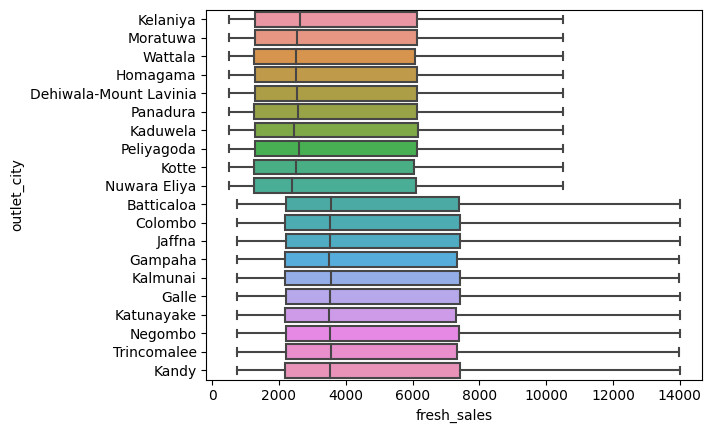

In [57]:
sns.boxplot(train_df, x='fresh_sales', y='outlet_city')

<Axes: xlabel='dry_sales', ylabel='outlet_city'>

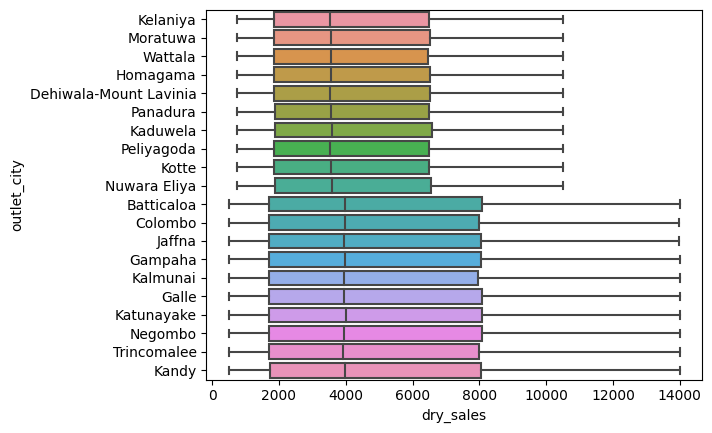

In [58]:
sns.boxplot(train_df, x='dry_sales', y='outlet_city')

<Axes: xlabel='luxury_sales', ylabel='outlet_city'>

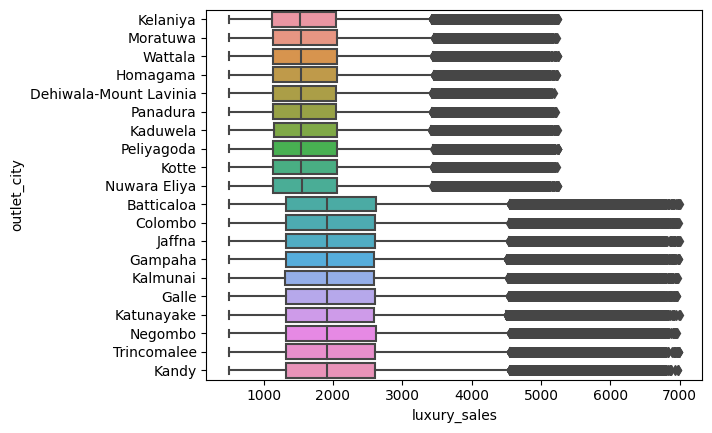

In [59]:
sns.boxplot(train_df, x='luxury_sales', y='outlet_city')

<Axes: xlabel='cluster_category', ylabel='outlet_city'>

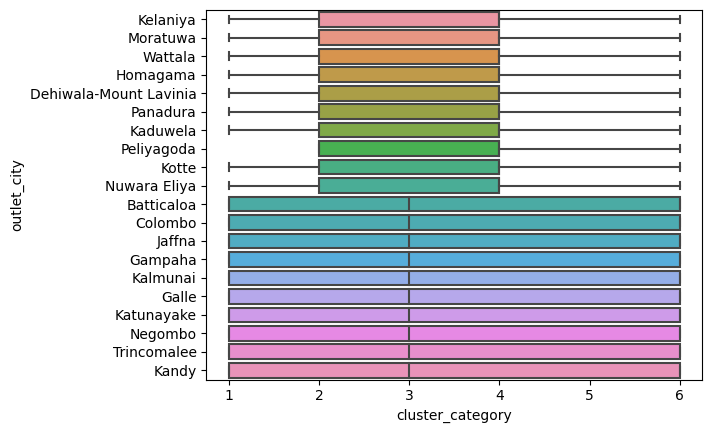

In [60]:
sns.boxplot(train_df, x='cluster_category', y='outlet_city')

It is clear that there is a subgrouping in the way the stores and the other features are distributed. 

The order of the outlet cities is the order of appearance.

It is seens that the first 10 stores, namely,
- Kelaniya, Moratuwa, Wattala, Homagama, Dehiwala-Mount Lavinia, Panadura, Kaduwela, Peliyagoda, Kotte and Nuwara Eliya

and
- Batticaloa, Colombo, Jaffna, Gampaha, Kalmunai, Galle, Katunayake, Negombo, Trincomalee, Kandy

form two informal clusters of cities.

It would be better to create a variable to represent these 2 informal clusters and we can name as `city_type` and use 0 and 1 respectively for the 2 types

The key differentiation of this city type could be due to number of customers visited for each store where the `city_type_cluster0` has customer counts of less than 40,000 while the `city_type_cluster1` has customer counts of more than 40,000

Text(0.5, 1.0, 'Number of Customers Visited per store')

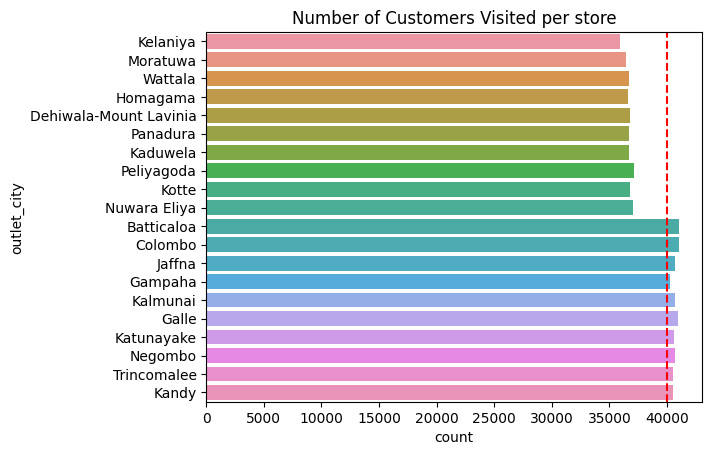

In [61]:
grp1 = pd.DataFrame(train_df.outlet_city.value_counts()[list(train_df['outlet_city'].unique())]).reset_index()
sns.barplot(grp1, y='outlet_city', x='count')
plt.axvline(x=40000, color='r', linestyle='--')
plt.title('Number of Customers Visited per store')

In [62]:
city_type_0_list = list(train_df['outlet_city'].unique())[:10]
city_type_1_list = list(train_df['outlet_city'].unique())[10:]

In [63]:
train_df['city_type'] = train_df['outlet_city'].isin(city_type_1_list).astype(int)
train_df

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_category,city_type
0,10493832.0,Kelaniya,1209.60,756.00,5292.00,4,0
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1,0
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4,0
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4,0
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4,0
...,...,...,...,...,...,...,...
774150,10197979.0,Gampaha,3893.40,3893.40,3448.44,3,1
774151,10494575.0,Katunayake,6095.86,5557.99,6275.15,3,1
774152,10565682.0,Colombo,5121.42,4820.16,4669.53,3,1
774153,10351977.0,Kandy,6311.76,6311.76,5940.48,3,1


### Cleaning Outlet City in Test Dataset

In [64]:
set(test_df['outlet_city'].unique()) - set(train_df['outlet_city'].unique())

{'Anuradhapura',
 'Madawachiya',
 'MoraTuwa',
 'PeliyagodA',
 'Trincomale',
 'batticaloa',
 'kalmunai'}

In [65]:
train_df['outlet_city'].unique()

array(['Kelaniya', 'Moratuwa', 'Wattala', 'Homagama',
       'Dehiwala-Mount Lavinia', 'Panadura', 'Kaduwela', 'Peliyagoda',
       'Kotte', 'Nuwara Eliya', 'Batticaloa', 'Colombo', 'Jaffna',
       'Gampaha', 'Kalmunai', 'Galle', 'Katunayake', 'Negombo',
       'Trincomalee', 'Kandy'], dtype=object)

In [66]:
list(test_df['outlet_city'].unique())

['batticaloa',
 'Batticaloa',
 'Colombo',
 'Dehiwala-Mount Lavinia',
 'Anuradhapura',
 'Galle',
 'Gampaha',
 'Homagama',
 'Jaffna',
 'Kaduwela',
 'Kalmunai',
 'kalmunai',
 'Kandy',
 'Katunayake',
 'Kelaniya',
 'Madawachiya',
 'Kotte',
 'Moratuwa',
 'MoraTuwa',
 'Negombo',
 'Nuwara Eliya',
 'Panadura',
 'Peliyagoda',
 'PeliyagodA',
 'Trincomale',
 'Trincomalee',
 'Wattala']

Since there are duplicate names with different spellings need to replace them and fix

In [67]:
test_df = test_df.replace('batticaloa','Batticaloa')
test_df = test_df.replace('kalmunai','Kalmunai')
test_df = test_df.replace('MoraTuwa','Moratuwa')
test_df = test_df.replace('PeliyagodA','Peliyagoda')
test_df = test_df.replace('Trincomale','Trincomalee')

In [68]:
print('Cities that are only found in the Test Dataset and not in the Training set')
set(test_df['outlet_city'].unique()) - set(train_df['outlet_city'].unique())

Cities that are only found in the Test Dataset and not in the Training set


{'Anuradhapura', 'Madawachiya'}

In [69]:
test_df.loc[test_df.outlet_city.isin(['Anuradhapura', 'Madawachiya'])]

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales
6192,10321,Anuradhapura,1708.80,3246.72,11107.20
6193,16217,Anuradhapura,1810.50,3077.85,12673.50
6194,22360,Anuradhapura,1228.78,1755.40,5880.59
6195,11471,Anuradhapura,1642.55,2021.60,8339.10
6196,6151,Anuradhapura,1119.16,1358.98,5515.86
...,...,...,...,...,...
26509,18853,Madawachiya,1629.42,8272.44,2130.78
26510,34070,Madawachiya,975.45,4226.95,1170.54
26511,26102,Madawachiya,741.73,4585.24,1348.60
26512,36534,Madawachiya,1417.32,7913.37,2125.98


In [70]:
print('Percentage of records in test dataset with no outlet city in training dataset')
round((test_df.loc[test_df.outlet_city.isin(['Anuradhapura', 'Madawachiya'])].shape[0] / test_df.shape[0])*100,2)

Percentage of records in test dataset with no outlet city in training dataset


7.72

Since Anuradhapura and Madawachiya are only found in the test dataset we could argue these cities are very low in customer counts. Hence we will allocate them to the city type 0

In [73]:
print("City Type 1 List : ",city_type_1_list)
print("City Type 0 List : ",city_type_0_list + ["Anuradhapura","Madawachiya"])
test_df['city_type'] = test_df['outlet_city'].isin(city_type_1_list).astype(int)
test_df

City Type 1 List :  ['Batticaloa', 'Colombo', 'Jaffna', 'Gampaha', 'Kalmunai', 'Galle', 'Katunayake', 'Negombo', 'Trincomalee', 'Kandy']
City Type 0 List :  ['Kelaniya', 'Moratuwa', 'Wattala', 'Homagama', 'Dehiwala-Mount Lavinia', 'Panadura', 'Kaduwela', 'Peliyagoda', 'Kotte', 'Nuwara Eliya', 'Anuradhapura', 'Madawachiya']


,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,city_type
0,33574,Batticaloa,2686.50,3582.00,12537.00,1
1,10089,Batticaloa,1717.56,2576.34,9446.58,1
2,38329,Batticaloa,854.04,1242.24,5201.88,1
3,11376,Batticaloa,1638.12,2320.67,9282.68,1
4,12410,Batticaloa,1039.09,1518.67,5435.24,1
...,...,...,...,...,...,...
40744,33698,Wattala,3916.48,4161.26,3916.48,0
40745,4185,Wattala,3191.92,3004.16,3098.04,0
40746,28664,Wattala,3838.60,3951.50,3700.00,0
40747,11874,Wattala,4313.76,4183.04,4313.76,0


Since the cities within each cluster type have very similar characteristics as seen in the plot distributions showcased earlier, we could use the city type as the feature instead of the exact city name.

## Applying Binary Encoding to the Cities [Optional]

In [74]:
encoder = ce.BinaryEncoder(cols=['outlet_city'])

# Apply BinaryEncoder to the DataFrame
city_train_encoded_df = encoder.fit_transform(train_df['outlet_city'])
city_train_encoded_df

,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,outlet_city_4
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,0,1,1
3,0,0,0,1,1
4,0,0,0,0,1
...,...,...,...,...,...
774150,0,1,1,1,0
774151,1,0,0,0,1
774152,0,1,1,0,0
774153,1,0,1,0,0


In [75]:
train_df['outlet_city_0'] = city_train_encoded_df['outlet_city_0']
train_df['outlet_city_1'] = city_train_encoded_df['outlet_city_1']
train_df['outlet_city_2'] = city_train_encoded_df['outlet_city_2']
train_df['outlet_city_3'] = city_train_encoded_df['outlet_city_3']
train_df['outlet_city_4'] = city_train_encoded_df['outlet_city_4']
train_df

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_category,city_type,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,outlet_city_4
0,10493832.0,Kelaniya,1209.60,756.00,5292.00,4,0,0,0,0,0,1
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1,0,0,0,0,1,0
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4,0,0,0,0,1,1
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4,0,0,0,0,1,1
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
774150,10197979.0,Gampaha,3893.40,3893.40,3448.44,3,1,0,1,1,1,0
774151,10494575.0,Katunayake,6095.86,5557.99,6275.15,3,1,1,0,0,0,1
774152,10565682.0,Colombo,5121.42,4820.16,4669.53,3,1,0,1,1,0,0
774153,10351977.0,Kandy,6311.76,6311.76,5940.48,3,1,1,0,1,0,0


In [76]:
city_test_encoded_df = encoder.transform(test_df['outlet_city'])

test_df['outlet_city_0'] = city_test_encoded_df['outlet_city_0']
test_df['outlet_city_1'] = city_test_encoded_df['outlet_city_1']
test_df['outlet_city_2'] = city_test_encoded_df['outlet_city_2']
test_df['outlet_city_3'] = city_test_encoded_df['outlet_city_3']
test_df['outlet_city_4'] = city_test_encoded_df['outlet_city_4']
test_df

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,city_type,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,outlet_city_4
0,33574,Batticaloa,2686.50,3582.00,12537.00,1,0,1,0,1,1
1,10089,Batticaloa,1717.56,2576.34,9446.58,1,0,1,0,1,1
2,38329,Batticaloa,854.04,1242.24,5201.88,1,0,1,0,1,1
3,11376,Batticaloa,1638.12,2320.67,9282.68,1,0,1,0,1,1
4,12410,Batticaloa,1039.09,1518.67,5435.24,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
40744,33698,Wattala,3916.48,4161.26,3916.48,0,0,0,0,1,1
40745,4185,Wattala,3191.92,3004.16,3098.04,0,0,0,0,1,1
40746,28664,Wattala,3838.60,3951.50,3700.00,0,0,0,0,1,1
40747,11874,Wattala,4313.76,4183.04,4313.76,0,0,0,0,1,1


# Feature Engineering

## New Features

In [80]:
# Sales ratio features
train_df['luxury_fresh_ratio'] = train_df['luxury_sales'] / train_df['fresh_sales']
train_df['luxury_dry_ratio'] = train_df['luxury_sales'] / train_df['dry_sales']
train_df['fresh_dry_ratio'] = train_df['fresh_sales'] / train_df['dry_sales']

test_df['luxury_fresh_ratio'] = test_df['luxury_sales'] / test_df['fresh_sales']
test_df['luxury_dry_ratio'] = test_df['luxury_sales'] / test_df['dry_sales']
test_df['fresh_dry_ratio'] = test_df['fresh_sales'] / test_df['dry_sales']

In [81]:
train_df.describe()

,Customer_ID,luxury_sales,fresh_sales,dry_sales,cluster_category,city_type,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,outlet_city_4,luxury_fresh_ratio,luxury_dry_ratio,fresh_dry_ratio
count,7.740490e+05,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000
mean,1.038708e+07,1921.947797,4428.714079,4676.292337,3.292143,0.525875,0.262771,0.406536,0.452238,0.499731,0.499382,0.700333,0.672087,2.194441
std,2.234822e+05,1004.042819,3334.737384,3409.411266,1.867038,0.499330,0.440140,0.491187,0.497714,0.500000,0.500000,0.484937,0.493833,2.242541
min,1.000000e+07,500.000000,500.000000,500.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142857,0.142857
25%,1.019353e+07,1213.530000,1620.130000,1787.940000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.238806,0.223881,0.230769
50%,1.038708e+07,1715.280000,3356.480000,3727.760000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.611111,0.968750
75%,1.058062e+07,2338.690000,6671.700000,7162.300000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.033333,1.032258,4.312500
max,1.077416e+07,6999.650000,13997.900000,13999.300000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,7.000000


In [82]:
test_df.describe()

,Customer_ID,luxury_sales,fresh_sales,dry_sales,city_type,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,outlet_city_4,luxury_fresh_ratio,luxury_dry_ratio,fresh_dry_ratio
count,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000
mean,20375.000000,1927.068008,4442.969841,4691.508888,0.485484,0.218778,0.374267,0.454342,0.498368,0.465827,0.701566,0.671333,2.193673
std,11763.367396,1003.797058,3349.438752,3410.980901,0.499795,0.413423,0.483939,0.497917,0.500003,0.498837,0.487231,0.493374,2.241996
min,1.000000,500.800000,500.300000,500.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.142840,0.142857
25%,10188.000000,1220.400000,1619.550000,1799.520000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.238806,0.223881,0.230769
50%,20375.000000,1721.720000,3369.060000,3755.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.611111,0.968750
75%,30562.000000,2346.120000,6697.140000,7183.440000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.033333,1.032258,4.312500
max,40749.000000,6985.650000,13995.100000,13989.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,7.000000


## Scaling for values

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='luxury_sales', ylabel='Count'>

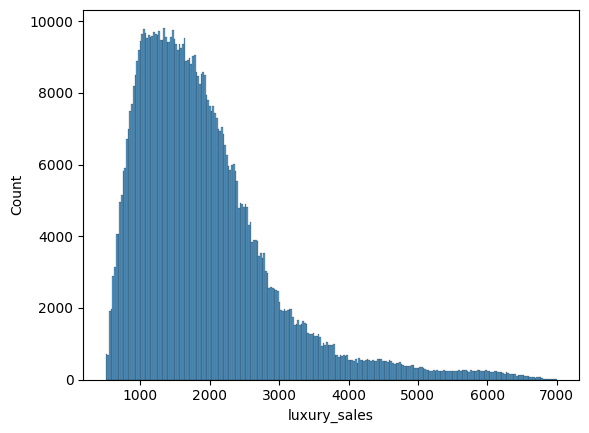

In [83]:
sns.histplot(train_df, x='luxury_sales')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='fresh_sales', ylabel='Count'>

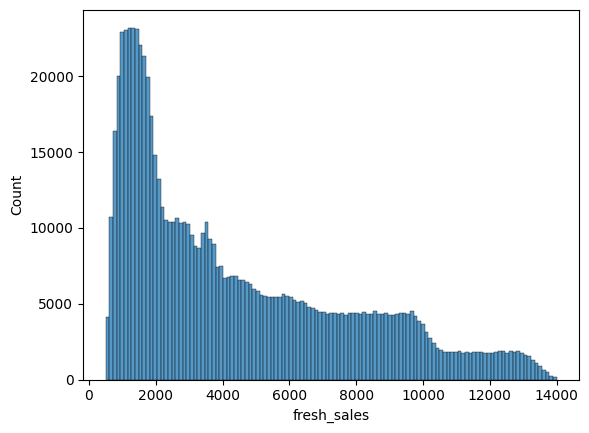

In [84]:
sns.histplot(train_df, x='fresh_sales')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='dry_sales', ylabel='Count'>

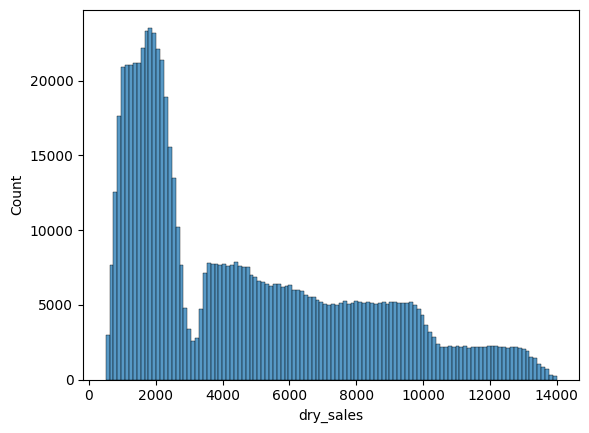

In [85]:
sns.histplot(train_df, x='dry_sales')

## Applying Log Scaling to obtain near normal distribution in sales values

In [86]:
train_df['log_luxury_sales'] = np.log(train_df['luxury_sales'])
train_df['log_dry_sales'] = np.log(train_df['dry_sales'])
train_df['log_fresh_sales'] = np.log(train_df['fresh_sales'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='log_luxury_sales', ylabel='Count'>

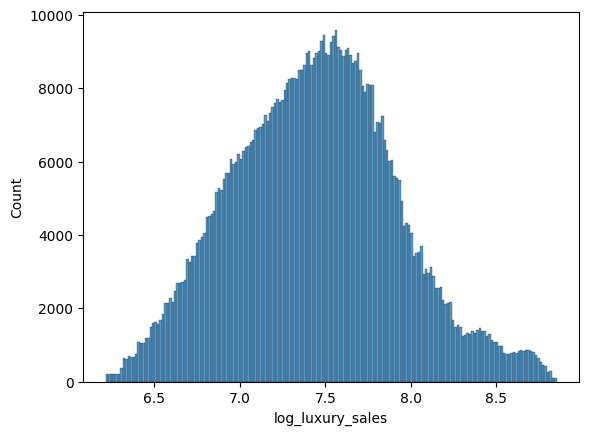

In [87]:
sns.histplot(train_df, x='log_luxury_sales')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='log_fresh_sales', ylabel='Count'>

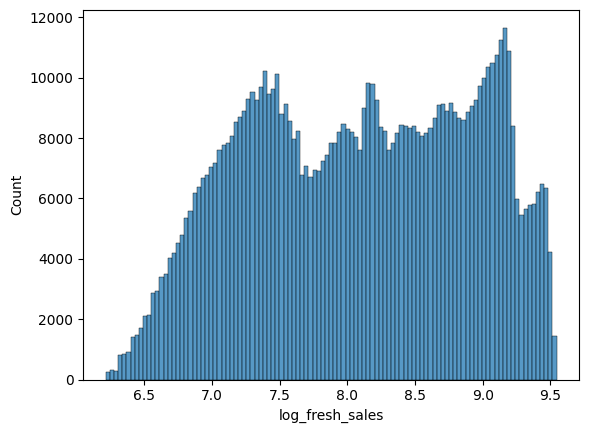

In [88]:
sns.histplot(train_df, x='log_fresh_sales')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='log_dry_sales', ylabel='Count'>

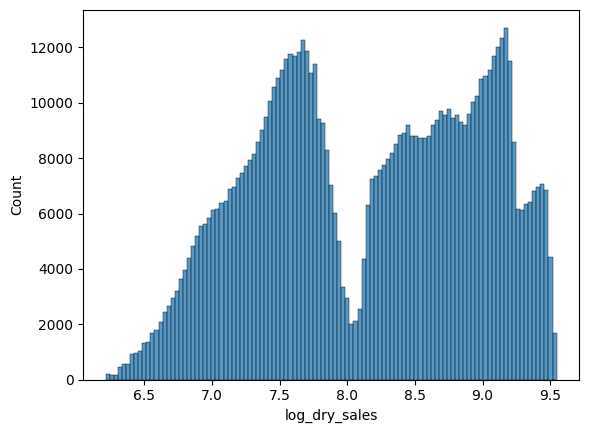

In [89]:
sns.histplot(train_df, x='log_dry_sales')

### Using Min Max Scaling

In [90]:
train_df = train_df.reset_index().drop(columns='index')

In [91]:
scaler = MinMaxScaler()

In [92]:
scaled_train_values = scaler.fit_transform(train_df[['log_luxury_sales','log_fresh_sales','log_dry_sales','luxury_fresh_ratio','luxury_dry_ratio','fresh_dry_ratio']])
scaled_train_df = pd.DataFrame(scaled_train_values, columns=['log_luxury_sales_scaled','log_fresh_sales_scaled','log_dry_sales_scaled', 'lux_fresh_scaled','lux_dry_scaled','fresh_dry_scaled'])
scaled_train_df

,log_luxury_sales_scaled,log_fresh_sales_scaled,log_dry_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled
0,0.334761,0.124078,0.708053,0.784615,0.046154,3.469447e-18
1,0.438406,0.225534,0.746092,0.730769,0.065611,4.901961e-03
2,0.576433,0.325893,0.872560,0.755245,0.057692,2.757353e-03
3,0.574118,0.374195,0.870726,0.627219,0.057692,7.046569e-03
4,0.585690,0.426307,0.875446,0.533333,0.059701,1.181592e-02
...,...,...,...,...,...,...
774044,0.777728,0.615965,0.579526,0.461538,0.531017,1.438172e-01
774045,0.947613,0.722792,0.759192,0.513648,0.446154,1.083333e-01
774046,0.881611,0.680047,0.670499,0.495192,0.513648,1.297043e-01
774047,0.960801,0.760960,0.742744,0.461538,0.495192,1.341146e-01


In [93]:
scaled_train_df.describe()

,log_luxury_sales_scaled,log_fresh_sales_scaled,log_dry_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled
count,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000,774049.000000
mean,0.465589,0.561522,0.581401,0.300179,0.284970,0.299189
std,0.181955,0.246395,0.242387,0.261120,0.265910,0.327037
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.335990,0.352831,0.382399,0.051665,0.043628,0.012821
50%,0.467116,0.571431,0.602900,0.282051,0.252137,0.120443
75%,0.584590,0.777605,0.798876,0.479487,0.478908,0.608073
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
train_df['log_luxury_sales_scaled'] = scaled_train_df['log_luxury_sales_scaled']
train_df['log_dry_sales_scaled'] = scaled_train_df['log_dry_sales_scaled']
train_df['log_fresh_sales_scaled'] = scaled_train_df['log_fresh_sales_scaled']
train_df['lux_fresh_scaled'] = scaled_train_df['lux_fresh_scaled']
train_df['lux_dry_scaled'] = scaled_train_df['lux_dry_scaled']
train_df['fresh_dry_scaled'] = scaled_train_df['fresh_dry_scaled']

train_df

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_category,city_type,outlet_city_0,outlet_city_1,outlet_city_2,...,fresh_dry_ratio,log_luxury_sales,log_dry_sales,log_fresh_sales,log_luxury_sales_scaled,log_dry_sales_scaled,log_fresh_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled
0,10493832.0,Kelaniya,1209.60,756.00,5292.00,4,0,0,0,0,...,0.142857,7.098045,8.573952,6.628041,0.334761,0.708053,0.124078,0.784615,0.046154,3.469447e-18
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1,0,0,0,0,...,0.176471,7.371565,8.700701,6.966100,0.438406,0.746092,0.225534,0.730769,0.065611,4.901961e-03
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4,0,0,0,0,...,0.161765,7.735818,9.122112,7.300500,0.576433,0.872560,0.325893,0.755245,0.057692,2.757353e-03
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4,0,0,0,0,...,0.191176,7.729709,9.116003,7.461445,0.574118,0.870726,0.374195,0.627219,0.057692,7.046569e-03
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4,0,0,0,0,...,0.223881,7.760250,9.131729,7.635086,0.585690,0.875446,0.426307,0.533333,0.059701,1.181592e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774044,10197979.0,Gampaha,3893.40,3893.40,3448.44,3,1,0,1,1,...,1.129032,8.267038,8.145677,8.267038,0.777728,0.579526,0.615965,0.461538,0.531017,1.438172e-01
774045,10494575.0,Katunayake,6095.86,5557.99,6275.15,3,1,1,0,0,...,0.885714,8.715365,8.744353,8.622992,0.947613,0.759192,0.722792,0.513648,0.446154,1.083333e-01
774046,10565682.0,Colombo,5121.42,4820.16,4669.53,3,1,0,1,1,...,1.032258,8.541187,8.448814,8.480562,0.881611,0.670499,0.680047,0.495192,0.513648,1.297043e-01
774047,10351977.0,Kandy,6311.76,6311.76,5940.48,3,1,1,0,1,...,1.062500,8.750170,8.689545,8.750170,0.960801,0.742744,0.760960,0.461538,0.495192,1.341146e-01


## Applying the scaling to test dataset

In [95]:
test_df['log_luxury_sales'] = np.log(test_df['luxury_sales'])
test_df['log_dry_sales'] = np.log(test_df['dry_sales'])
test_df['log_fresh_sales'] = np.log(test_df['fresh_sales'])

test_df

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,city_type,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,outlet_city_4,luxury_fresh_ratio,luxury_dry_ratio,fresh_dry_ratio,log_luxury_sales,log_dry_sales,log_fresh_sales
0,33574,Batticaloa,2686.50,3582.00,12537.00,1,0,1,0,1,1,0.750000,0.214286,0.285714,7.895995,9.436440,8.183677
1,10089,Batticaloa,1717.56,2576.34,9446.58,1,0,1,0,1,1,0.666667,0.181818,0.272727,7.448660,9.153408,7.854125
2,38329,Batticaloa,854.04,1242.24,5201.88,1,0,1,0,1,1,0.687500,0.164179,0.238806,6.749978,8.556775,7.124671
3,11376,Batticaloa,1638.12,2320.67,9282.68,1,0,1,0,1,1,0.705882,0.176471,0.250000,7.401305,9.135906,7.749611
4,12410,Batticaloa,1039.09,1518.67,5435.24,1,0,1,0,1,1,0.684211,0.191176,0.279412,6.946101,8.600659,7.325590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40744,33698,Wattala,3916.48,4161.26,3916.48,0,0,0,0,1,1,0.941176,1.000000,1.062500,8.272949,8.272949,8.333573
40745,4185,Wattala,3191.92,3004.16,3098.04,0,0,0,0,1,1,1.062500,1.030303,0.969697,8.068378,8.038525,8.007753
40746,28664,Wattala,3838.60,3951.50,3700.00,0,0,0,0,1,1,0.971429,1.037459,1.067973,8.252863,8.216088,8.281851
40747,11874,Wattala,4313.76,4183.04,4313.76,0,0,0,0,1,1,1.031250,1.000000,0.969697,8.369565,8.369565,8.338794


In [96]:
scaled_test_values = scaler.transform(test_df[['log_luxury_sales','log_fresh_sales','log_dry_sales','luxury_fresh_ratio','luxury_dry_ratio','fresh_dry_ratio']])
scaled_test_df = pd.DataFrame(scaled_test_values, columns=['log_luxury_sales_scaled','log_fresh_sales_scaled','log_dry_sales_scaled', 'lux_fresh_scaled','lux_dry_scaled','fresh_dry_scaled'])
scaled_test_df.describe()

,log_luxury_sales_scaled,log_fresh_sales_scaled,log_dry_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled
count,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000,40749.000000
mean,0.466791,0.562398,0.582593,0.300843,0.284564,0.299077
std,0.181599,0.246409,0.242270,0.262355,0.265663,0.326958
min,0.000606,0.000180,0.000540,0.000000,-0.000009,0.000000
25%,0.338129,0.352724,0.384336,0.051665,0.043628,0.012821
50%,0.468536,0.572554,0.605112,0.282051,0.252137,0.120443
75%,0.585792,0.778747,0.799761,0.479487,0.478908,0.608073
max,0.999241,0.999940,0.999790,1.000000,1.000000,1.000000


In [97]:
test_df['log_luxury_sales_scaled'] = scaled_test_df['log_luxury_sales_scaled']
test_df['log_dry_sales_scaled'] = scaled_test_df['log_dry_sales_scaled']
test_df['log_fresh_sales_scaled'] = scaled_test_df['log_fresh_sales_scaled']

test_df['lux_fresh_scaled'] = scaled_test_df['lux_fresh_scaled']
test_df['lux_dry_scaled'] = scaled_test_df['lux_dry_scaled']
test_df['fresh_dry_scaled'] = scaled_test_df['fresh_dry_scaled']

test_df

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,city_type,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,...,fresh_dry_ratio,log_luxury_sales,log_dry_sales,log_fresh_sales,log_luxury_sales_scaled,log_dry_sales_scaled,log_fresh_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled
0,33574,Batticaloa,2686.50,3582.00,12537.00,1,0,1,0,1,...,0.285714,7.895995,9.436440,8.183677,0.637128,0.966891,0.590947,0.326923,0.038462,0.020833
1,10089,Batticaloa,1717.56,2576.34,9446.58,1,0,1,0,1,...,0.272727,7.448660,9.153408,7.854125,0.467620,0.881952,0.492044,0.282051,0.020979,0.018939
2,38329,Batticaloa,854.04,1242.24,5201.88,1,0,1,0,1,...,0.238806,6.749978,8.556775,7.124671,0.202868,0.702899,0.273124,0.293269,0.011481,0.013993
3,11376,Batticaloa,1638.12,2320.67,9282.68,1,0,1,0,1,...,0.250000,7.401305,9.135906,7.749611,0.449675,0.876699,0.460678,0.303167,0.018100,0.015625
4,12410,Batticaloa,1039.09,1518.67,5435.24,1,0,1,0,1,...,0.279412,6.946101,8.600659,7.325590,0.277185,0.716068,0.333423,0.291498,0.026018,0.019914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40744,33698,Wattala,3916.48,4161.26,3916.48,0,0,0,0,1,...,1.062500,8.272949,8.272949,8.333573,0.779968,0.617721,0.635934,0.429864,0.461538,0.134115
40745,4185,Wattala,3191.92,3004.16,3098.04,0,0,0,0,1,...,0.969697,8.068378,8.038525,8.007753,0.702450,0.547369,0.538150,0.495192,0.477855,0.120581
40746,28664,Wattala,3838.60,3951.50,3700.00,0,0,0,0,1,...,1.067973,8.252863,8.216088,8.281851,0.772357,0.600656,0.620411,0.446154,0.481709,0.134913
40747,11874,Wattala,4313.76,4183.04,4313.76,0,0,0,0,1,...,0.969697,8.369565,8.369565,8.338794,0.816579,0.646716,0.637500,0.478365,0.461538,0.120581


# Correlation Analysis

In [98]:
train_df.columns

Index(['Customer_ID', 'outlet_city', 'luxury_sales', 'fresh_sales',
       'dry_sales', 'cluster_category', 'city_type', 'outlet_city_0',
       'outlet_city_1', 'outlet_city_2', 'outlet_city_3', 'outlet_city_4',
       'luxury_fresh_ratio', 'luxury_dry_ratio', 'fresh_dry_ratio',
       'log_luxury_sales', 'log_dry_sales', 'log_fresh_sales',
       'log_luxury_sales_scaled', 'log_dry_sales_scaled',
       'log_fresh_sales_scaled', 'lux_fresh_scaled', 'lux_dry_scaled',
       'fresh_dry_scaled'],
      dtype='object')

In [99]:
num_df = train_df[['luxury_sales','fresh_sales','dry_sales','city_type','luxury_fresh_ratio','luxury_dry_ratio','fresh_dry_ratio','cluster_category']]

<Axes: >

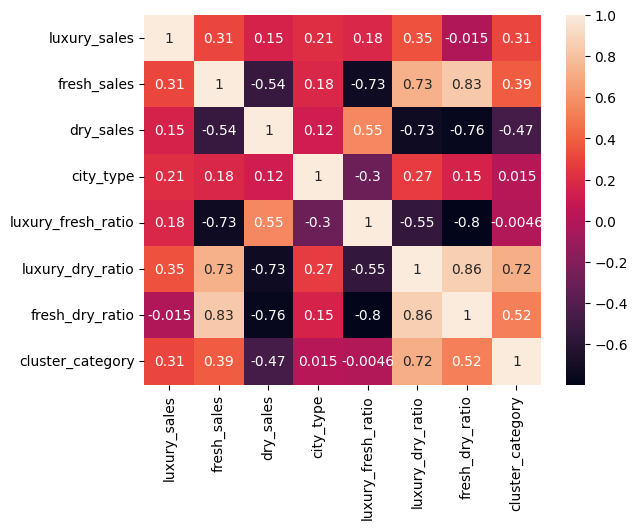

In [100]:
sns.heatmap(num_df.corr(), annot=True)

# Analysis on Cluster Target Variable

Text(0.5, 1.0, 'Distribution of Luxury Sales by Customer Clusters')

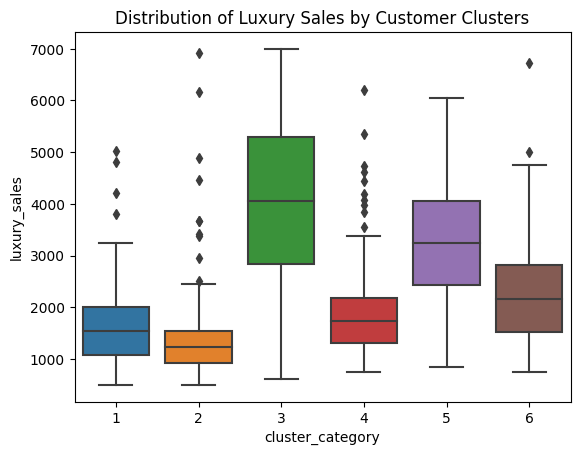

In [101]:
sns.boxplot(train_df, x='cluster_category', y='luxury_sales')
plt.title("Distribution of Luxury Sales by Customer Clusters")

Text(0.5, 1.0, 'Distribution of Fresh Sales by Customer Clusters')

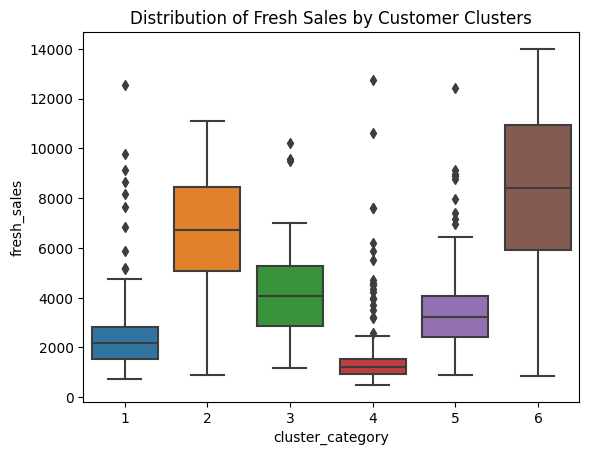

In [102]:
sns.boxplot(train_df, x='cluster_category', y='fresh_sales')
plt.title("Distribution of Fresh Sales by Customer Clusters")

Text(0.5, 1.0, 'Distribution of Dry Sales by Customer Clusters')

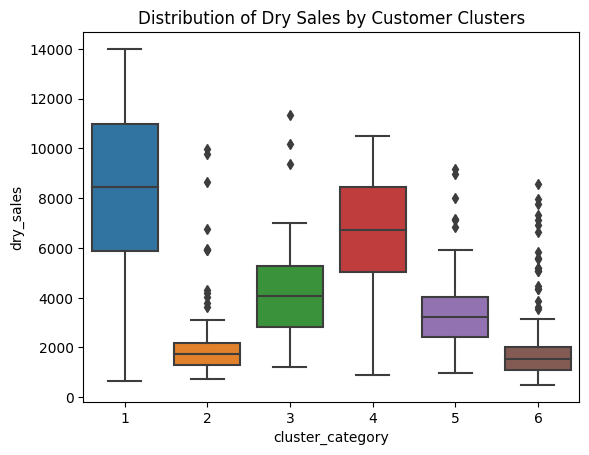

In [103]:
sns.boxplot(train_df, x='cluster_category', y='dry_sales')
plt.title("Distribution of Dry Sales by Customer Clusters")

In [104]:
# train_df.mean().sort_values().index
train_df['total_sales'] = train_df['fresh_sales'] + train_df['dry_sales'] + train_df['luxury_sales']
# index_tot_sales = train_df.groupby(['cluster_category'])['total_sales'].mean().sort_values().index

Text(0.5, 1.0, 'Distribution of Total Sales by Customer Clusters')

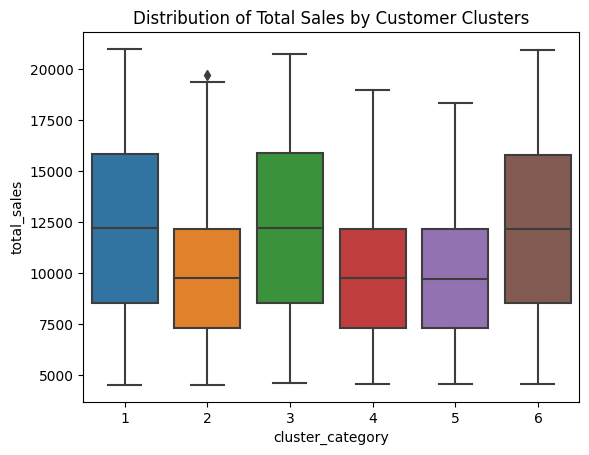

In [105]:
sns.boxplot(train_df, x='cluster_category', y='total_sales')
plt.title("Distribution of Total Sales by Customer Clusters")

Text(0.5, 1.0, 'Distribution of Luxury/Fresh Ratio by Customer Clusters')

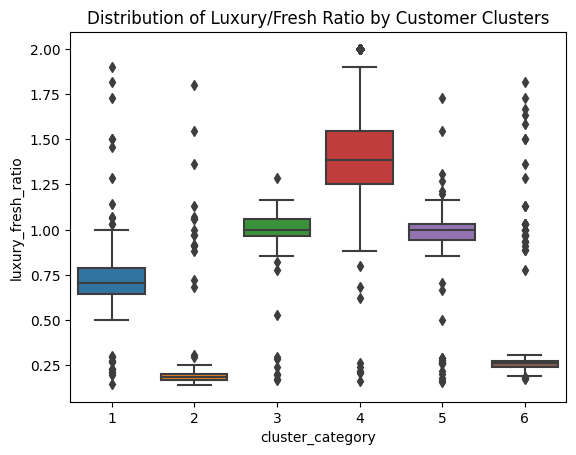

In [106]:
sns.boxplot(train_df, x='cluster_category', y='luxury_fresh_ratio')
plt.title("Distribution of Luxury/Fresh Ratio by Customer Clusters")

Text(0.5, 1.0, 'Distribution of Luxury/Dry Ratio by Customer Clusters')

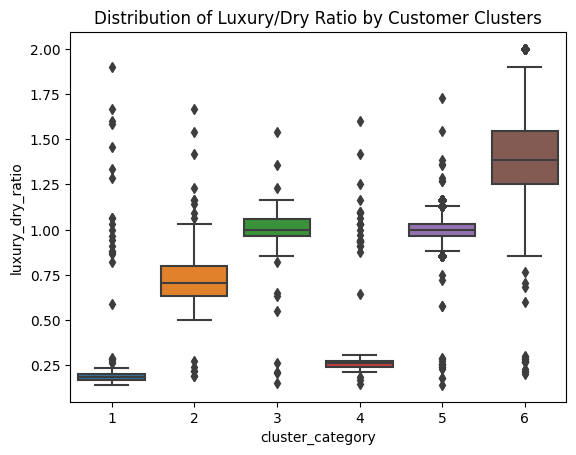

In [107]:
sns.boxplot(train_df, x='cluster_category', y='luxury_dry_ratio')
plt.title("Distribution of Luxury/Dry Ratio by Customer Clusters")

Text(0.5, 1.0, 'Distribution of Fresh/Dry Ratio by Customer Clusters')

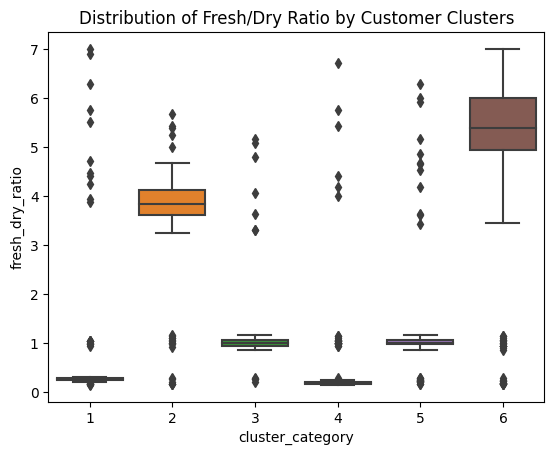

In [108]:
sns.boxplot(train_df, x='cluster_category', y='fresh_dry_ratio')
plt.title("Distribution of Fresh/Dry Ratio by Customer Clusters")

<Axes: xlabel='cluster_category', ylabel='outlet_city'>

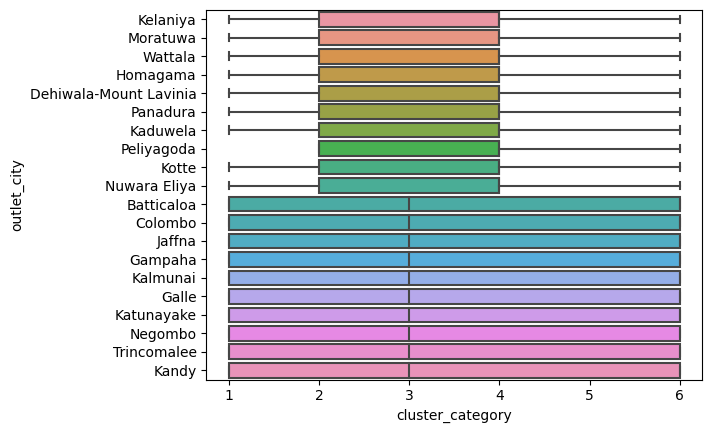

In [109]:
sns.boxplot(train_df, x='cluster_category', y='outlet_city')

<Axes: xlabel='city_type', ylabel='cluster_category'>

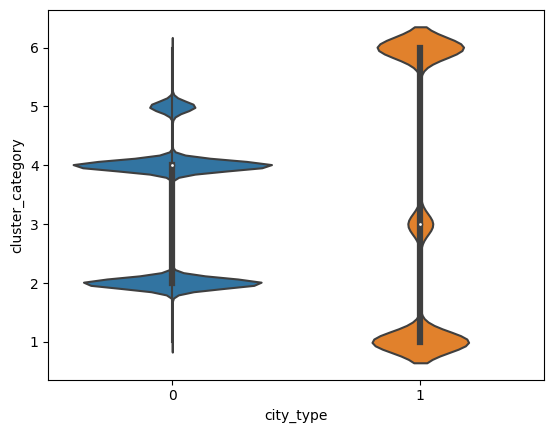

In [110]:
sns.violinplot(train_df, x='city_type', y='cluster_category')

# Model Training

In [111]:
train_final_df = train_df[['Customer_ID','city_type','log_luxury_sales_scaled','log_dry_sales_scaled','log_fresh_sales_scaled','cluster_category']]

In [112]:
test_final_df = test_df[['Customer_ID','city_type','log_luxury_sales_scaled','log_dry_sales_scaled','log_fresh_sales_scaled']]

In [113]:
# v2_columns = ['Customer_ID','city_type','outlet_city_0','outlet_city_1','outlet_city_2','outlet_city_3','outlet_city_4','log_luxury_sales_scaled','log_dry_sales_scaled','log_fresh_sales_scaled']

# v3_columns = ['Customer_ID','outlet_city_0','outlet_city_1','outlet_city_2','outlet_city_3','outlet_city_4','log_luxury_sales_scaled','log_dry_sales_scaled','log_fresh_sales_scaled']

v4_columns = ['Customer_ID','city_type','log_luxury_sales_scaled','log_dry_sales_scaled','log_fresh_sales_scaled', 'lux_fresh_scaled','lux_dry_scaled','fresh_dry_scaled']

train_final_df = train_df[v4_columns+['cluster_category']]
test_final_df = test_df[v4_columns]

In [114]:
X_df = train_final_df.drop(columns=['cluster_category','Customer_ID'])
y_df = train_final_df['cluster_category']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.15, random_state=42)

## Random Forest

In [116]:
# model = RandomForestClassifier()

In [117]:
# model.fit(X_train, y_train)

In [118]:
# y_val = model.predict(X_train)
# cm_train = confusion_matrix(y_train, y_val)
# cm_train

In [119]:
# print("Train Accuracy")
# accuracy_score(y_train, y_val)*100

In [120]:
# y_pred = model.predict(X_test)
# cm_test = confusion_matrix(y_test, y_pred)
# cm_test

In [121]:
# print("Test Accuracy")
# accuracy_score(y_test, y_pred)*100

### Feature Importance

In [122]:
# importances = model.feature_importances_

# # Get the names of the features
# feature_names = X_train.columns

# # Sort feature importances in descending order
# indices = np.argsort(importances)[::-1]

# # Plot the feature importances
# plt.figure(figsize=(10, 6))
# plt.title("Feature Importances")
# plt.bar(range(X_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
# plt.xlim([-1, X_train.shape[1]])
# plt.tight_layout()
# plt.show()

## XGBoost

In [116]:
y_train-1

137845    3
234076    1
586009    5
238122    1
241870    1
         ..
259178    1
365838    4
131932    3
671155    5
121958    3
Name: cluster_category, Length: 657941, dtype: int64

In [117]:
model = XGBClassifier()
model.fit(X_train, (y_train-1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [118]:
y_val = model.predict(X_train)
cm_train = confusion_matrix((y_train-1), y_val)
cm_train

array([[160483,      4,      6,      9,      0,      7],
       [     2, 131871,      3,      3,      4,      2],
       [     3,      3,  41580,      1,      5,      3],
       [     3,      3,      6, 146546,     10,      2],
       [     0,      1,      5,      6,  33518,      7],
       [     3,      4,      7,      6,      8, 143817]])

In [119]:
print("Train Accuracy")
accuracy_score((y_train-1), y_val)*100

Train Accuracy


99.98084934667393

In [120]:
y_test-1

457210    0
245354    1
539193    0
691681    5
766381    2
         ..
76694     3
331605    4
59343     3
558260    5
720720    5
Name: cluster_category, Length: 116108, dtype: int64

In [121]:
y_pred = model.predict(X_test)
cm_test = confusion_matrix((y_test-1), y_pred)
cm_test

array([[28450,     0,     1,     0,     1,     0],
       [    0, 23150,     1,     1,     0,     3],
       [    0,     1,  7294,     0,     0,     0],
       [    0,     0,     0, 25855,     1,     1],
       [    2,     3,     1,     3,  5978,     1],
       [    0,     0,     1,     3,     0, 25357]])

In [122]:
print("Test Accuracy")
accuracy_score((y_test-1), y_pred)*100

Test Accuracy


99.97932958969236

## KNN

In [130]:
# best_acc = 0
# best_k = 0
# for n in range(3, 20):
#     model = KNeighborsClassifier(n_neighbors=n)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     score = accuracy_score(y_test, y_pred)*100
#     print(f"K = {n} : accuracy = {score}")
#     if score > best_acc:
#         best_acc = score
#         best_k = n

In [131]:
# model = KNeighborsClassifier(n_neighbors=best_k)
# model.fit(X_train, y_train)
# y_val = model.predict(X_train)
# cm_train = confusion_matrix((y_train), y_val)
# print(cm_train)
# print(f"Train Accuracy : {accuracy_score(y_train, y_val)*100}")

# y_pred = model.predict(X_test)
# cm_test = confusion_matrix(y_test, y_pred)
# print(cm_test)
# print(f"Test Accuracy : {accuracy_score(y_test, y_pred)*100}")

In [132]:
# model = KNeighborsClassifier(n_neighbors=5)
# model.fit(X_train, y_train)

In [133]:
# y_val = model.predict(X_train)
# cm_train = confusion_matrix((y_train), y_val)
# cm_train

In [134]:
# print("Train Accuracy")
# accuracy_score(y_train, y_val)*100

In [135]:
# y_pred = model.predict(X_test)
# cm_test = confusion_matrix(y_test, y_pred)
# cm_test

In [136]:
# print("Test Accuracy")
# accuracy_score(y_test, y_pred)*100

## Neural Network

In [125]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

In [124]:
# X_train.shape

In [182]:
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(7,)),  # Adjust input_shape according to your data
#     Dense(32, activation='relu'),
#     Dense(6, activation='softmax')  # Output layer with 6 units for 6 output types, softmax activation for classification
# ])
# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [183]:
# X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [123]:
# model.fit(X_train_1, y_train_1-1, epochs=5, batch_size=32, validation_data=(X_val_1, y_val_1-1))  # Adjust epochs and batch_size as needed

In [142]:
# test_loss, test_accuracy = model.evaluate(X_test, y_test-1)
# print("Test Accuracy:", test_accuracy*100)
# print("Test Loss :", test_loss)

In [126]:
# predictions = model.predict(X_test)

# # If you have integer-encoded target values, you may want to convert the predicted probabilities to class labels
# predicted_classes = predictions.argmax(axis=1)

# # If you have one-hot encoded target values, you may want to convert the predicted probabilities to class labels
# import numpy as np
# predicted_classes = np.argmax(predictions, axis=1)

# # Now you have the predicted classes for the new data
# predicted_classes+1

In [127]:
# accuracy_score(y_test, predicted_classes+1)*100

### Analyzing Prediction

In [128]:
X_train_9, X_test_9, y_train_9, y_test_9 = train_test_split(train_df.drop(columns=['cluster_category']), train_df['cluster_category'], test_size=0.15, random_state=42)

In [129]:
preds_test_df = pd.concat([pd.concat([X_test_9, y_test_9], axis=1).reset_index(), pd.Series(y_pred+1)],axis=1)
preds_test_df.loc[preds_test_df['cluster_category'] != preds_test_df[0]].describe()

,index,Customer_ID,luxury_sales,fresh_sales,dry_sales,city_type,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,...,log_fresh_sales,log_luxury_sales_scaled,log_dry_sales_scaled,log_fresh_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled,total_sales,cluster_category,0
count,24.00000,2.400000e+01,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,328464.37500,1.044677e+07,1899.710417,4207.842083,3663.442917,0.458333,0.083333,0.416667,0.541667,0.541667,...,7.988261,0.480263,0.542401,0.532300,0.353225,0.320033,0.276554,9770.995417,4.041667,3.750000
std,280379.89956,2.199964e+05,737.078509,3551.964300,2325.201390,0.508977,0.282330,0.503610,0.508977,0.508977,...,0.877980,0.140296,0.184994,0.263495,0.280396,0.244992,0.302675,3213.943825,1.680558,1.594829
min,1133.00000,1.001688e+07,904.920000,866.580000,1099.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.764554,0.224796,0.236348,0.165047,0.008919,0.019518,0.002083,5271.420000,1.000000,1.000000
25%,4156.75000,1.030462e+07,1300.365000,1452.680000,1891.462500,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.276370,0.362177,0.399190,0.318651,0.062352,0.067890,0.011877,7526.775000,2.000000,2.750000
50%,328275.00000,1.044624e+07,1627.960000,2493.920000,2526.115000,0.000000,0.000000,0.000000,1.000000,1.000000,...,7.819930,0.447276,0.486100,0.481781,0.422398,0.319444,0.129562,8296.850000,5.000000,4.000000
75%,557641.50000,1.063584e+07,2444.965000,6592.137500,5283.160000,1.000000,0.000000,1.000000,1.000000,1.000000,...,8.792395,0.601392,0.707441,0.773633,0.498077,0.483685,0.529040,11693.157500,5.000000,5.000000
max,753167.00000,1.074473e+07,3536.610000,12745.200000,8955.220000,1.000000,1.000000,1.000000,1.000000,1.000000,...,9.452910,0.741307,0.865921,0.971863,0.820513,0.751479,0.805556,18431.520000,6.000000,6.000000


In [130]:
preds_test_df.loc[preds_test_df['cluster_category'] == preds_test_df[0]].describe()

,index,Customer_ID,luxury_sales,fresh_sales,dry_sales,city_type,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,...,log_fresh_sales,log_luxury_sales_scaled,log_dry_sales_scaled,log_fresh_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled,total_sales,cluster_category,0
count,116084.00000,1.160840e+05,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000,...,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000,116084.000000
mean,387003.48601,1.038743e+07,1919.703411,4420.777207,4673.512279,0.526352,0.262784,0.407085,0.451880,0.500586,...,8.083229,0.465216,0.581495,0.560801,0.300492,0.284710,0.298643,11013.992897,3.291444,3.291444
std,223240.52198,2.232916e+05,1001.559025,3335.575575,3401.484745,0.499307,0.440148,0.491293,0.497681,0.500002,...,0.821273,0.181831,0.242030,0.246476,0.260941,0.266087,0.327005,3829.192213,1.868016,1.868016
min,7.00000,1.000000e+07,500.200000,500.000000,500.200000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.214608,0.000152,0.000120,0.000000,0.000000,0.000000,0.000000,4509.900000,1.000000,1.000000
25%,194134.50000,1.019441e+07,1212.992500,1617.117500,1790.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.388401,0.335822,0.382744,0.352273,0.051665,0.043628,0.012821,7821.000000,2.000000,2.000000
50%,387750.00000,1.038728e+07,1711.665000,3339.570000,3733.345000,1.000000,0.000000,0.000000,0.000000,1.000000,...,8.113597,0.466317,0.603349,0.569915,0.282051,0.252137,0.120443,10739.785000,3.000000,3.000000
75%,579427.25000,1.058123e+07,2336.820000,6657.140000,7151.947500,1.000000,1.000000,1.000000,1.000000,1.000000,...,8.803445,0.584287,0.798442,0.776949,0.479487,0.478908,0.608073,13719.375000,5.000000,5.000000
max,774046.00000,1.077414e+07,6999.650000,13997.900000,13999.300000,1.000000,1.000000,1.000000,1.000000,1.000000,...,9.546663,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,20979.000000,6.000000,6.000000


In [131]:
preds_test_df.loc[preds_test_df['cluster_category'] != preds_test_df[0]].outlet_city.value_counts()

outlet_city
Moratuwa                  5
Panadura                  3
Colombo                   3
Jaffna                    3
Kelaniya                  2
Gampaha                   2
Kaduwela                  1
Galle                     1
Dehiwala-Mount Lavinia    1
Batticaloa                1
Peliyagoda                1
Trincomalee               1
Name: count, dtype: int64

# Predicting for Test Dataset

In [132]:
test_X = test_final_df.drop(columns=['Customer_ID'])
# test_X = test_X.drop(columns=['cluster_category'])
test_final_df

,Customer_ID,city_type,log_luxury_sales_scaled,log_dry_sales_scaled,log_fresh_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled
0,33574,1,0.637128,0.966891,0.590947,0.326923,0.038462,0.020833
1,10089,1,0.467620,0.881952,0.492044,0.282051,0.020979,0.018939
2,38329,1,0.202868,0.702899,0.273124,0.293269,0.011481,0.013993
3,11376,1,0.449675,0.876699,0.460678,0.303167,0.018100,0.015625
4,12410,1,0.277185,0.716068,0.333423,0.291498,0.026018,0.019914
...,...,...,...,...,...,...,...,...
40744,33698,0,0.779968,0.617721,0.635934,0.429864,0.461538,0.134115
40745,4185,0,0.702450,0.547369,0.538150,0.495192,0.477855,0.120581
40746,28664,0,0.772357,0.600656,0.620411,0.446154,0.481709,0.134913
40747,11874,0,0.816579,0.646716,0.637500,0.478365,0.461538,0.120581


In [133]:
test_X

,city_type,log_luxury_sales_scaled,log_dry_sales_scaled,log_fresh_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled
0,1,0.637128,0.966891,0.590947,0.326923,0.038462,0.020833
1,1,0.467620,0.881952,0.492044,0.282051,0.020979,0.018939
2,1,0.202868,0.702899,0.273124,0.293269,0.011481,0.013993
3,1,0.449675,0.876699,0.460678,0.303167,0.018100,0.015625
4,1,0.277185,0.716068,0.333423,0.291498,0.026018,0.019914
...,...,...,...,...,...,...,...
40744,0,0.779968,0.617721,0.635934,0.429864,0.461538,0.134115
40745,0,0.702450,0.547369,0.538150,0.495192,0.477855,0.120581
40746,0,0.772357,0.600656,0.620411,0.446154,0.481709,0.134913
40747,0,0.816579,0.646716,0.637500,0.478365,0.461538,0.120581


In [134]:
test_df['cluster_category'] = model.predict(test_X)+1
test_df

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,city_type,outlet_city_0,outlet_city_1,outlet_city_2,outlet_city_3,...,log_luxury_sales,log_dry_sales,log_fresh_sales,log_luxury_sales_scaled,log_dry_sales_scaled,log_fresh_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled,cluster_category
0,33574,Batticaloa,2686.50,3582.00,12537.00,1,0,1,0,1,...,7.895995,9.436440,8.183677,0.637128,0.966891,0.590947,0.326923,0.038462,0.020833,1
1,10089,Batticaloa,1717.56,2576.34,9446.58,1,0,1,0,1,...,7.448660,9.153408,7.854125,0.467620,0.881952,0.492044,0.282051,0.020979,0.018939,1
2,38329,Batticaloa,854.04,1242.24,5201.88,1,0,1,0,1,...,6.749978,8.556775,7.124671,0.202868,0.702899,0.273124,0.293269,0.011481,0.013993,1
3,11376,Batticaloa,1638.12,2320.67,9282.68,1,0,1,0,1,...,7.401305,9.135906,7.749611,0.449675,0.876699,0.460678,0.303167,0.018100,0.015625,1
4,12410,Batticaloa,1039.09,1518.67,5435.24,1,0,1,0,1,...,6.946101,8.600659,7.325590,0.277185,0.716068,0.333423,0.291498,0.026018,0.019914,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40744,33698,Wattala,3916.48,4161.26,3916.48,0,0,0,0,1,...,8.272949,8.272949,8.333573,0.779968,0.617721,0.635934,0.429864,0.461538,0.134115,5
40745,4185,Wattala,3191.92,3004.16,3098.04,0,0,0,0,1,...,8.068378,8.038525,8.007753,0.702450,0.547369,0.538150,0.495192,0.477855,0.120581,5
40746,28664,Wattala,3838.60,3951.50,3700.00,0,0,0,0,1,...,8.252863,8.216088,8.281851,0.772357,0.600656,0.620411,0.446154,0.481709,0.134913,5
40747,11874,Wattala,4313.76,4183.04,4313.76,0,0,0,0,1,...,8.369565,8.369565,8.338794,0.816579,0.646716,0.637500,0.478365,0.461538,0.120581,5


In [135]:
test_final_df['cluster_category'] = model.predict(test_X)+1
test_final_df

/tmp/ipykernel_33/2348246313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_final_df['cluster_category'] = model.predict(test_X)+1


,Customer_ID,city_type,log_luxury_sales_scaled,log_dry_sales_scaled,log_fresh_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled,cluster_category
0,33574,1,0.637128,0.966891,0.590947,0.326923,0.038462,0.020833,1
1,10089,1,0.467620,0.881952,0.492044,0.282051,0.020979,0.018939,1
2,38329,1,0.202868,0.702899,0.273124,0.293269,0.011481,0.013993,1
3,11376,1,0.449675,0.876699,0.460678,0.303167,0.018100,0.015625,1
4,12410,1,0.277185,0.716068,0.333423,0.291498,0.026018,0.019914,1
...,...,...,...,...,...,...,...,...,...
40744,33698,0,0.779968,0.617721,0.635934,0.429864,0.461538,0.134115,5
40745,4185,0,0.702450,0.547369,0.538150,0.495192,0.477855,0.120581,5
40746,28664,0,0.772357,0.600656,0.620411,0.446154,0.481709,0.134913,5
40747,11874,0,0.816579,0.646716,0.637500,0.478365,0.461538,0.120581,5


In [136]:
submission_df = test_final_df[['Customer_ID','cluster_category']]
submission_df

,Customer_ID,cluster_category
0,33574,1
1,10089,1
2,38329,1
3,11376,1
4,12410,1
...,...,...
40744,33698,5
40745,4185,5
40746,28664,5
40747,11874,5


In [137]:
submission_df.to_csv('submission_v13.csv', index=False)

# Analyzing Predictions set

In [145]:
test_df['total_sales'] = test_df['luxury_sales'] + test_df['dry_sales'] + test_df['fresh_sales']
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'
complete_df = pd.concat([train_df,test_df])
complete_df

,Customer_ID,outlet_city,luxury_sales,fresh_sales,dry_sales,cluster_category,city_type,outlet_city_0,outlet_city_1,outlet_city_2,...,log_dry_sales,log_fresh_sales,log_luxury_sales_scaled,log_dry_sales_scaled,log_fresh_sales_scaled,lux_fresh_scaled,lux_dry_scaled,fresh_dry_scaled,total_sales,dataset
0,10493832.0,Kelaniya,1209.60,756.00,5292.00,4,0,0,0,0,...,8.573952,6.628041,0.334761,0.708053,0.124078,0.784615,0.046154,3.469447e-18,7257.60,train
1,10178643.0,Moratuwa,1590.12,1060.08,6007.12,1,0,0,0,0,...,8.700701,6.966100,0.438406,0.746092,0.225534,0.730769,0.065611,4.901961e-03,8657.32,train
2,10513916.0,Wattala,2288.88,1481.04,9155.52,4,0,0,0,0,...,9.122112,7.300500,0.576433,0.872560,0.325893,0.755245,0.057692,2.757353e-03,12925.44,train
3,10334589.0,Wattala,2274.94,1739.66,9099.76,4,0,0,0,0,...,9.116003,7.461445,0.574118,0.870726,0.374195,0.627219,0.057692,7.046569e-03,13114.36,train
4,10458365.0,Kelaniya,2345.49,2069.55,9243.99,4,0,0,0,0,...,9.131729,7.635086,0.585690,0.875446,0.426307,0.533333,0.059701,1.181592e-02,13659.03,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40744,33698.0,Wattala,3916.48,4161.26,3916.48,5,0,0,0,0,...,8.272949,8.333573,0.779968,0.617721,0.635934,0.429864,0.461538,1.341146e-01,11994.22,test
40745,4185.0,Wattala,3191.92,3004.16,3098.04,5,0,0,0,0,...,8.038525,8.007753,0.702450,0.547369,0.538150,0.495192,0.477855,1.205808e-01,9294.12,test
40746,28664.0,Wattala,3838.60,3951.50,3700.00,5,0,0,0,0,...,8.216088,8.281851,0.772357,0.600656,0.620411,0.446154,0.481709,1.349127e-01,11490.10,test
40747,11874.0,Wattala,4313.76,4183.04,4313.76,5,0,0,0,0,...,8.369565,8.338794,0.816579,0.646716,0.637500,0.478365,0.461538,1.205808e-01,12810.56,test


In [146]:
complete_df.to_csv('complete_dataset.csv', index=False)

The rest of analysis is done on notebook named `descriptive_analysis.ipynb`